In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.ensemble import RandomForestRegressor 
import regression_common

np.random.seed(39)

In [2]:
# load lesion load matrix 
lesion_load_matrix = np.load('../data/lesions_load_matrix_absolute.npy')
print(lesion_load_matrix.shape)

# take log of lesion loads
lesion_load_df = pd.DataFrame(lesion_load_matrix)
lesion_load_log_df = np.log(1+lesion_load_df)

(1401, 144)


In [3]:
#patient_df.to_hdf('../data/patients.h5', key='p', mode='w')
patient_df = pd.read_hdf('../data/patients.h5', 'p')

## Multitask Analysis

In [4]:
scaler_X = StandardScaler()
X = scaler_X.fit_transform(lesion_load_log_df)

In [5]:
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))

### Multitask Ridge

In [8]:
def perform_multitask_ridge(X, Y):
    print('Performing Multitask Ridge regression (5-fold nested CV)')
    estimator = MultiTaskElasticNet(l1_ratio=0.001)
    alpha = np.linspace(0, 10, 51)
    my_grid={"alpha": alpha}
    return regression_common.perform_regression(X, Y, estimator, my_grid)

In [9]:
scores_mr = perform_multitask_ridge(X, Y)

Performing Multitask Ridge regression (5-fold nested CV)

Fold-1: Best params: {'alpha': 4.6000000000000005}

Fold-2: Best params: {'alpha': 5.6000000000000005}

Fold-3: Best params: {'alpha': 4.800000000000001}

Fold-4: Best params: {'alpha': 4.2}

Fold-5: Best params: {'alpha': 4.800000000000001}


### PLS

In [10]:
def perform_pls_regression(X, Y):
    print('Performing PLS regression (5-fold nested CV)')
    estimator = PLSRegression()
    n_components = np.linspace(1, 6, 6, dtype=int)
    my_grid={'n_components': n_components}
    return regression_common.perform_regression(X, Y, estimator, my_grid)

In [11]:
scores_pls = perform_pls_regression(X, Y)

Performing PLS regression (5-fold nested CV)

Fold-1: Best params: {'n_components': 2}

Fold-2: Best params: {'n_components': 1}

Fold-3: Best params: {'n_components': 1}

Fold-4: Best params: {'n_components': 1}

Fold-5: Best params: {'n_components': 2}


### CCA

In [12]:
def perform_cca(X, Y):
    print('Performing CCA (5-fold nested CV)')
    estimator = CCA(n_components=6)
    n_components = np.linspace(1, 6, 6, dtype=int)
    my_grid={'n_components': n_components}
    return regression_common.perform_regression(X, Y, estimator, my_grid)

In [13]:
scores_cca = perform_cca(X, Y)

Performing CCA (5-fold nested CV)

Fold-1: Best params: {'n_components': 1}

Fold-2: Best params: {'n_components': 1}

Fold-3: Best params: {'n_components': 1}

Fold-4: Best params: {'n_components': 1}

Fold-5: Best params: {'n_components': 1}


### Random Forest Regression

In [14]:
def perform_random_forest_regr(X, Y):
    print('Performing Random Forest regression (5-fold nested CV)')
    estimator = RandomForestRegressor(random_state=39)

    n_estimators = [10, 100, 500, 1000]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth = [2, 5, 10, 50, 100, None]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    max_samples = [0.4, 0.5, 0.7, 0.8]
    
    my_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}
    
    return regression_common.perform_regression(X, Y, estimator, my_grid, random_search_cv=True)

In [15]:
scores_rf = perform_random_forest_regr(X, Y)

Performing Random Forest regression (5-fold nested CV)

Fold-1: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}

Fold-2: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}

Fold-3: Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 'log2', 'max_depth': 10}

Fold-4: Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.4, 'max_features': 'log2', 'max_depth': 10}

Fold-5: Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 10}


### Neural Net

In [49]:
# For fun
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

def get_nn_model():
    model = Sequential()
    model.add(Dense(25, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation=None))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def perform_nn_regr(X, Y):
    print('Performing Neural Network regression (5-fold nested CV)')
    estimator = KerasRegressor(build_fn=get_nn_model, epochs=5, batch_size=32, verbose=1)
    return regression_common.perform_regression(X, Y, estimator, {}, nn=True)

In [50]:
scores_nn = perform_nn_regr(X, Y)

Performing Neural Network regression (5-fold nested CV)
Train on 1120 samples, validate on 281 samples
Epoch 1/5
1120/1120 [==============================] - 2s 2ms/step - loss: 0.9892 - val_loss: 1.0425
Epoch 2/5
1120/1120 [==============================] - 0s 121us/step - loss: 0.9774 - val_loss: 1.0457
Epoch 3/5
1120/1120 [==============================] - 0s 120us/step - loss: 0.9577 - val_loss: 1.0450
Epoch 4/5
1120/1120 [==============================] - 0s 116us/step - loss: 0.9512 - val_loss: 1.0456
Epoch 5/5
281/281 [==============================] - 0s 162us/step

Fold-1: Best params: {}
Train on 1121 samples, validate on 280 samples
Epoch 1/5
1121/1121 [==============================] - 2s 2ms/step - loss: 0.9832 - val_loss: 1.0694
Epoch 2/5
1121/1121 [==============================] - 0s 119us/step - loss: 0.9816 - val_loss: 1.0729
Epoch 3/5
1121/1121 [==============================] - 0s 120us/step - loss: 0.9724 - val_loss: 1.0845
Epoch 4/5
1121/1121 [====================

In [16]:
# Plot results

scores_all_models = pd.DataFrame()

scores_mr.insert(0, "Model", "Multitask Ridge")
scores_pls.insert(0, "Model", "PLS")
scores_cca.insert(0, "Model", "CCA")
scores_rf.insert(0, "Model", "Random Forest")
scores_nn.insert(0, "Model", "Neural Net")

scores_all_models = pd.concat([scores_mr, scores_pls, scores_cca, scores_rf, scores_nn], ignore_index=True)

In [54]:
# persist results
scores_all_models.to_hdf('../data/results_atlas_multioutput.h5', key='p', mode='w')
#scores_all_models = pd.read_hdf('../data/results_atlas_multitask.h5', key='p')

In [52]:
scores_nn.insert(0, "Model", "Neural Net")
scores_all_models = pd.concat([scores_all_models, scores_nn], ignore_index=True)

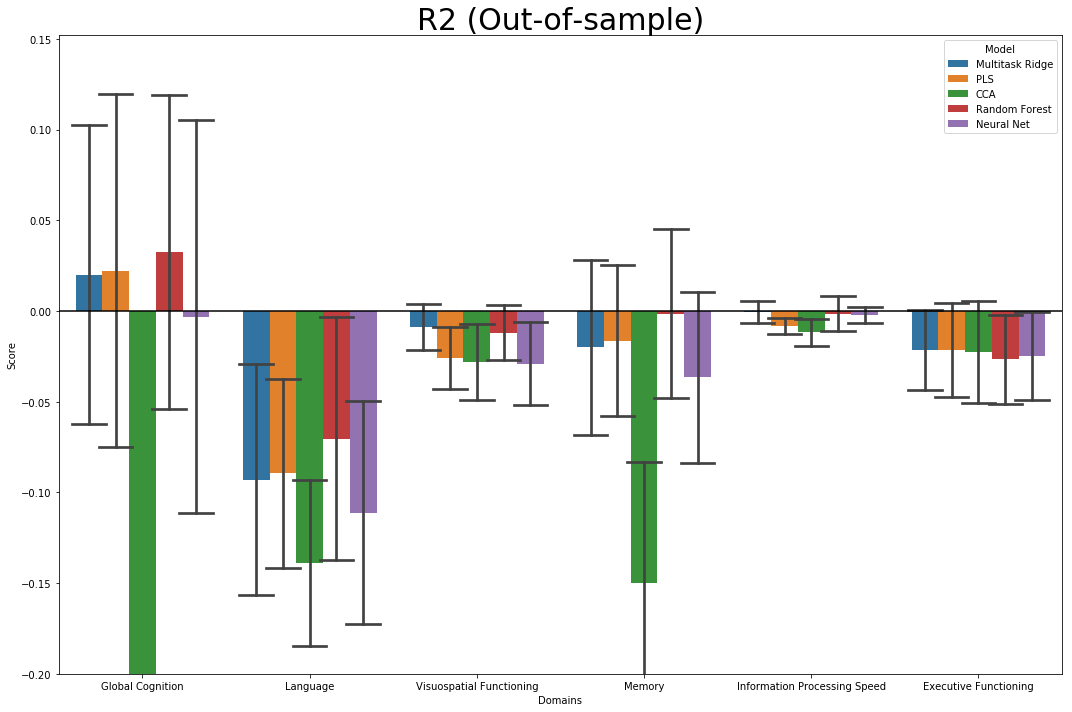

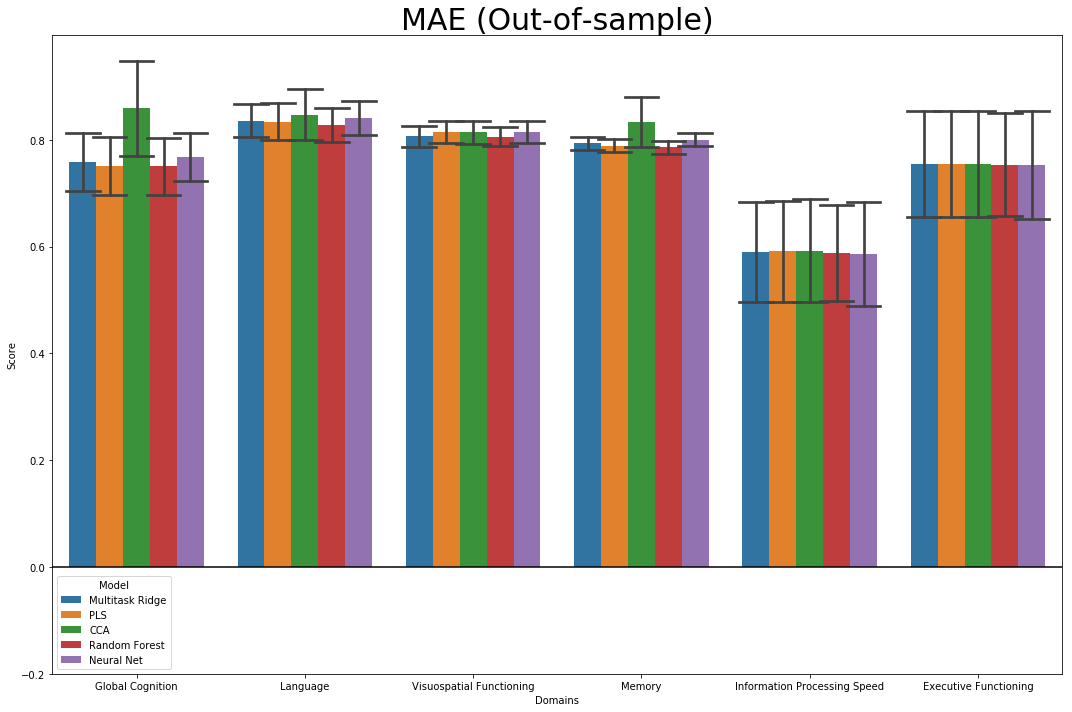

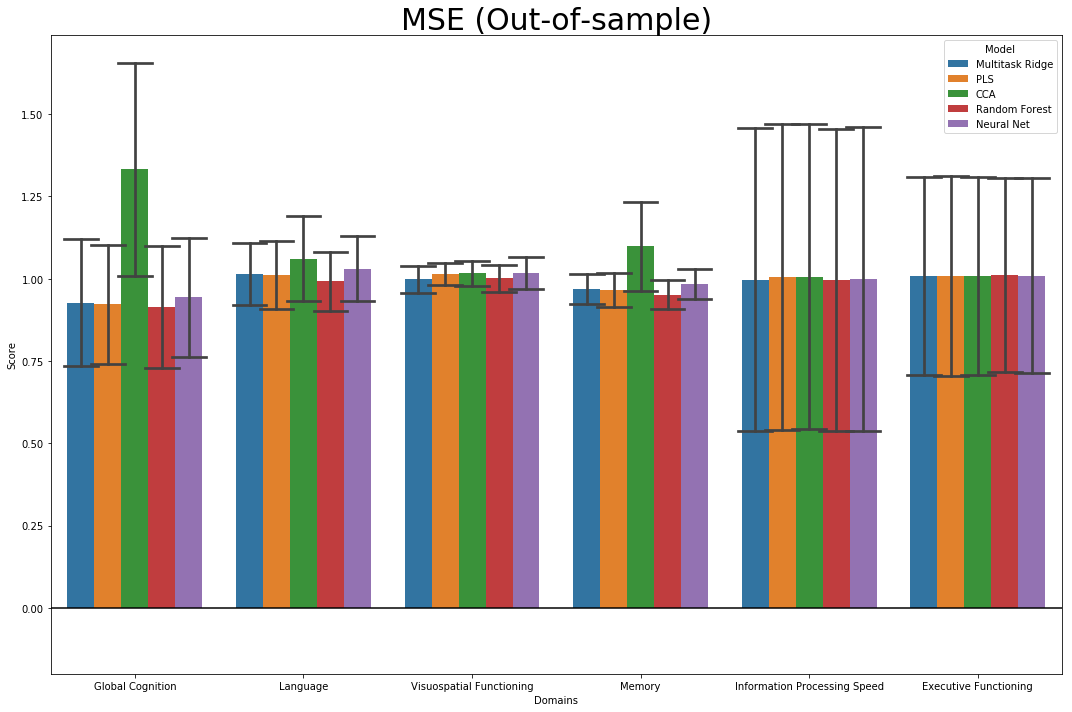

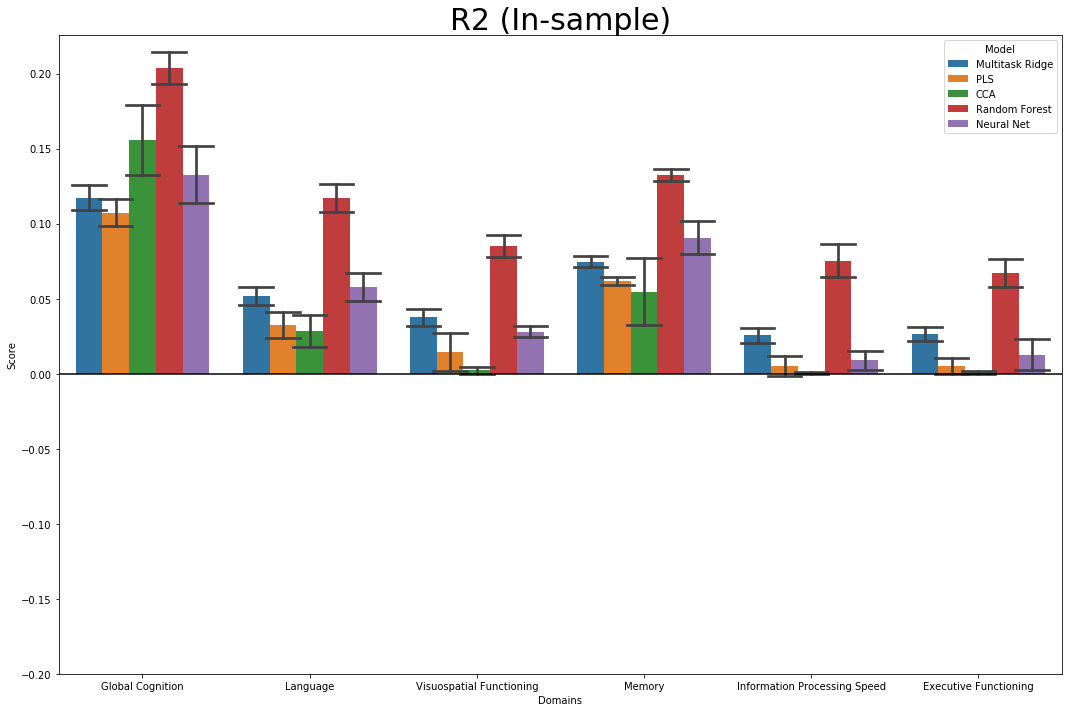

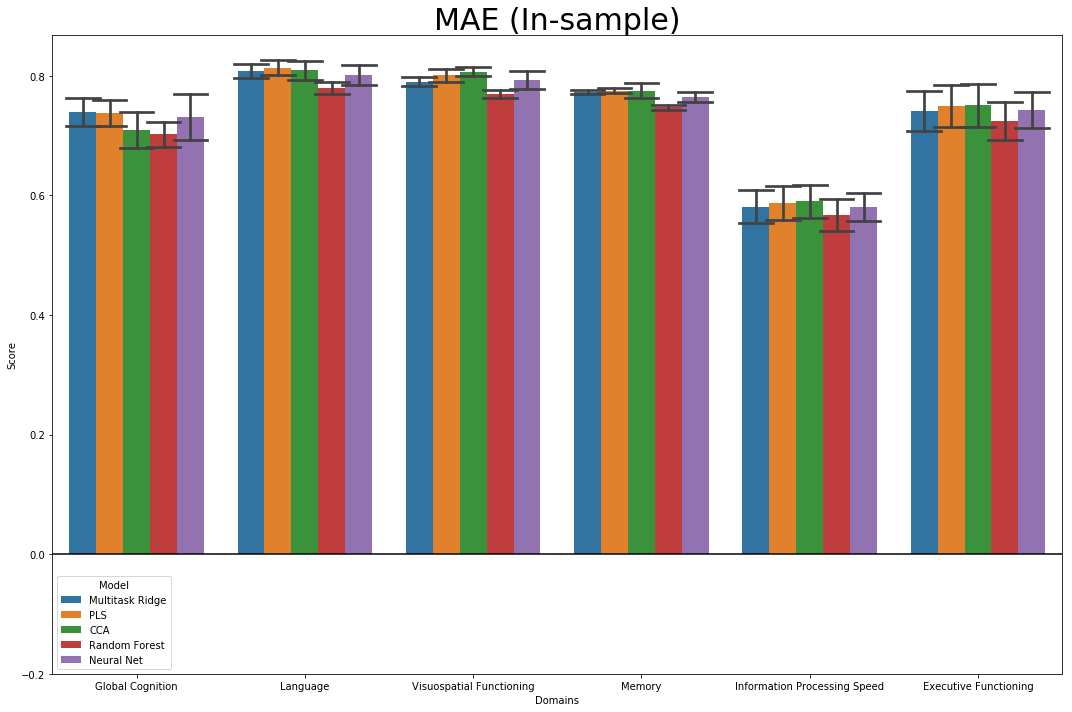

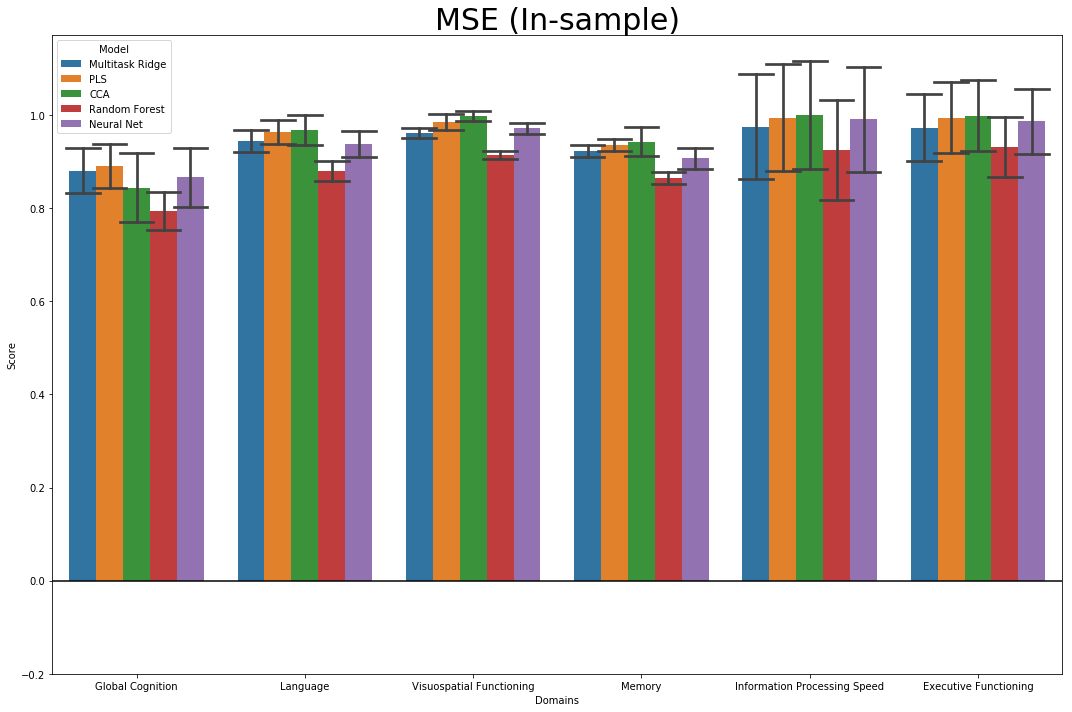

In [53]:
regression_common.plot_all_scores(scores_all_models)

In [ ]:
//Done